# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Загрузка CSV-файла с данными
labels = pd.read_csv('/datasets/faces/labels.csv')
labels


# Подсчет количества записей (размер выборки)
sample_size = len(labels)
print("Размер выборки:", sample_size)

Размер выборки: 7591


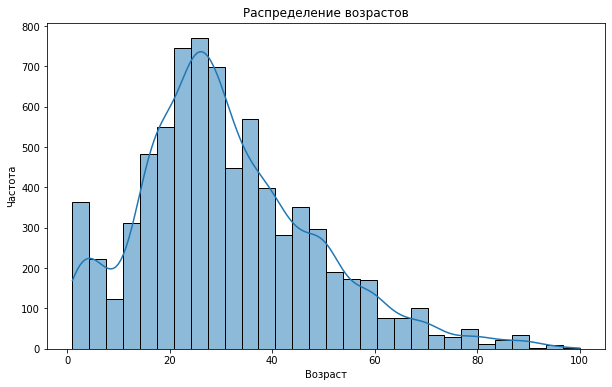

In [3]:
# Построение графика распределения возрастов
plt.figure(figsize=(10, 6))
sns.histplot(labels['real_age'], bins=30, kde=True)
plt.title('Распределение возрастов')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

In [4]:
# Путь к папке с изображениями
image_folder = '/datasets/faces/final_files/'

# Список файлов из DataFrame labels
image_files = labels['file_name'].tolist()

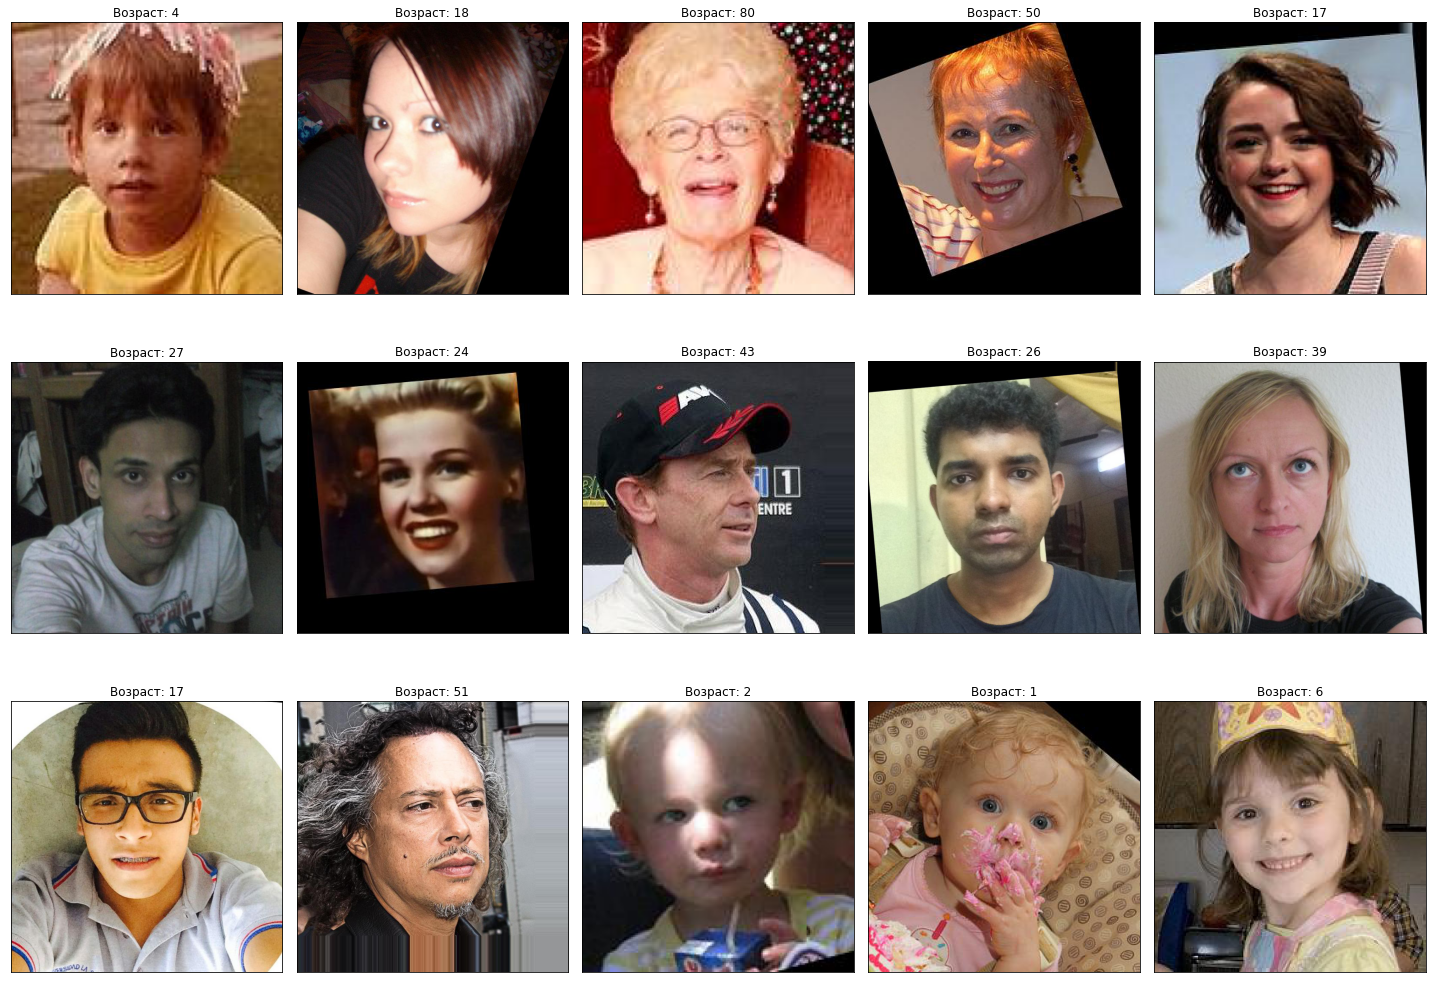

In [5]:
# Вывод 15 фотографий подряд с возрастами
fig = plt.figure(figsize=(20, 16))
for i in range(15):
    img_path = image_folder + image_files[i]
    img = Image.open(img_path)
    
    fig.add_subplot(3, 5, i + 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Возраст: ' + str(labels['real_age'][i]))
    
plt.show()

В данных наблюдаются разнообразные артефакты, такие как повернутые и сдвинутые изображения, а также фотографии, сделанные как в профиль, так и в анфас. Это многообразие может оказать положительное воздействие на процесс обучения модели и способствовать снижению переобучения.

Применение такого разнообразия данных может быть полезным по нескольким причинам:

Повышение устойчивости: Включение поворотов, сдвигов и других артефактов в обучающую выборку позволяет модели стать более устойчивой к различным вариациям входных данных. Это особенно важно в задачах анализа изображений, где реальные данные могут содержать разнообразные искажения.

Предотвращение переобучения: Добавление разнообразия в данные может снизить вероятность переобучения модели. Если модель сталкивается с разнообразными сценариями во время обучения, это может помочь ей генерализовать знания на новые, ранее не виденные данные.

На изображениях можно наблюдать людей разных возрастных групп, начиная от младенцев (1 год) и заканчивая людьми в глубукой старости (до 80 лет) - выборка репрезентативна.

Пики на круглых значениях (20, 40, 50) - их можно увидеть, если визуализировать распределение каждого возраста (в будущем рекомендую так делать для значений с дискретными значениями). Это может показывать на то, что для части фото настоящий возраст был неизвестен, или что фото, сделанных в юбилей, намного больше остальных
Смещение вправо показывает на малое количество людей пожилого возраста. Возможно модель плохо обучится на этих возрастах

## Обучение модели

```python

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np

np.random.seed(42)

def load_train(path, validation_split=0.2):
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=validation_split)

    train_data = train_datagen.flow_from_dataframe(
        labels,
        path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='training')

    validation_data = train_datagen.flow_from_dataframe(
        labels,
        path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='validation')

    return train_data, validation_data


    return test_data

def create_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=Adam(lr=0.0001), loss='mean_absolute_error', metrics=['mae'])

    return model

def train_model(model, train_data, validation_data, epochs=10):
    model.fit(train_data, validation_data=validation_data, epochs=epochs, verbose=2)
    return model

if __name__ == '__main__':
    train_data, validation_data = load_train('/datasets/faces/')
    test_data = load_test('/datasets/faces/')

    input_shape = (150, 150, 3)
    age_model = create_model(input_shape)
    trained_age_model = train_model(age_model, train_data, validation_data, epochs=10)
    
    Train for 238 steps, validate for 238 steps
Epoch 1/10
2023-08-20 13:17:21.883457: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-20 13:17:22.244791: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
238/238 - 116s - loss: 11.0211 - mae: 11.0401 - val_loss: 24.0560 - val_mae: 24.0852
Epoch 2/10
238/238 - 105s - loss: 8.0864 - mae: 8.1014 - val_loss: 14.2081 - val_mae: 14.2248
Epoch 3/10
238/238 - 106s - loss: 7.4108 - mae: 7.4221 - val_loss: 9.0610 - val_mae: 9.0633
Epoch 4/10
238/238 - 108s - loss: 7.0895 - mae: 7.1003 - val_loss: 6.7081 - val_mae: 6.7182
Epoch 5/10
238/238 - 112s - loss: 6.6050 - mae: 6.6066 - val_loss: 6.2490 - val_mae: 6.2597
Epoch 6/10
238/238 - 113s - loss: 6.3816 - mae: 6.3907 - val_loss: 6.2815 - val_mae: 6.2939
Epoch 7/10
238/238 - 113s - loss: 6.1837 - mae: 6.1889 - val_loss: 6.7565 - val_mae: 6.7634
Epoch 8/10
238/238 - 111s - loss: 6.0379 - mae: 6.0407 - val_loss: 7.4659 - val_mae: 7.4798
Epoch 9/10
238/238 - 104s - loss: 5.7515 - mae: 5.7547 - val_loss: 5.8434 - val_mae: 5.8494
Epoch 10/10
238/238 - 105s - loss: 5.6126 - mae: 5.6159 - val_loss: 5.2610 - val_mae: 5.2630
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
238/238 - 35s - loss: 5.2610 - mae: 5.2630
Test MAE: 5.2630


```

## Анализ обученной модели

В данном случае, модель достигла значения MAE (Mean Absolute Error) на тестовой выборке равного 5.2630. Это означает, что средняя абсолютная ошибка модели в предсказании возраста составляет около 5.26 лет.

Чем ниже значение MAE, тем лучше модель выполнила задачу. В данном случае, значение MAE в 5.26 можно считать достаточно низким, что свидетельствует о том, что модель довольно точно предсказывает возраст людей на тестовой выборке.

Возможно, стоило бы увеличить количество эпох обучения, чтобы дать модели больше времени на настройку весов и улучшение метрик. На протяжении первых 10 эпох функция потерь существенно снижалась, что может указывать на то, что инициализированные веса, предобученные на другом наборе данных, могли быть не совсем оптимальными для решения задачи распознавания возраста на данном датасете.

Увеличение числа эпох может помочь модели лучше адаптироваться к данным и улучшить метрики, однако следует также следить за процессом обучения, чтобы избежать переобучения. Это может включать в себя мониторинг графиков обучения, использование регуляризации и аугментации данных для обеспечения более стабильной работы модели.

Важно подбирать оптимальное количество эпох, чтобы достичь баланса между улучшением метрик и предотвращением переобучения, и, при необходимости, экспериментировать с разными гиперпараметрами модели для достижения наилучших результатов.